In [2]:
!pip install surprise
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS

     |████████████████████████████████| 11.8 MB 4.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619424 sha256=af955901972513d2187142b29adf086406f0d1452df6f8aff3b233ae010a2a46
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [5]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')

In [6]:
print(movies.info())
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
print(ratings.info())
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44917 entries, 0 to 44916
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     44917 non-null  int64  
 1   movieId    44917 non-null  int64  
 2   rating     44917 non-null  float64
 3   timestamp  44917 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.4 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
print(tags.info())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
#dropping the timestamp column because we don't need it
ratings = ratings.drop('timestamp', axis = 1)


Merging the movies and ratings dataframes for use later in this notebook

In [10]:
movie_ratings = pd.merge(movies, ratings)
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [11]:
#descriptive statistics
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [12]:
ratings.describe()

,userId,movieId,rating
count,44917.000000,44917.000000,44917.000000
mean,151.268607,18385.744061,3.548578
std,88.819567,35049.525043,1.033384
min,1.000000,1.000000,0.500000
25%,68.000000,1093.000000,3.000000
50%,153.000000,2763.000000,4.000000
75%,229.000000,7143.000000,4.000000
max,298.000000,193587.000000,5.000000



An analysis of the descriptive statistics of ratings df shows that the minimum rating score is 0.5 and the maximum is 5.0. The mean rating score is ~3.5 with a standard deviation of ~1.04

**Data Visualizations**

*Distribution of rating score in ratings df*

Showing the distribution of ratings given in the ratings dataset. In the plot below, we see that the rating scale ranges from 0.5 to 5.0 with increments of 0.5. The most prevalent ratings given are 3.0, and 4.0 with 5.0 coming in third. We also see that people were less likely to give low ratings as evidenced by the low number of movies rated between 0.5 and 2.5.

Text(0.5, 0.98, 'Frequency Distribution of Rating Scores')

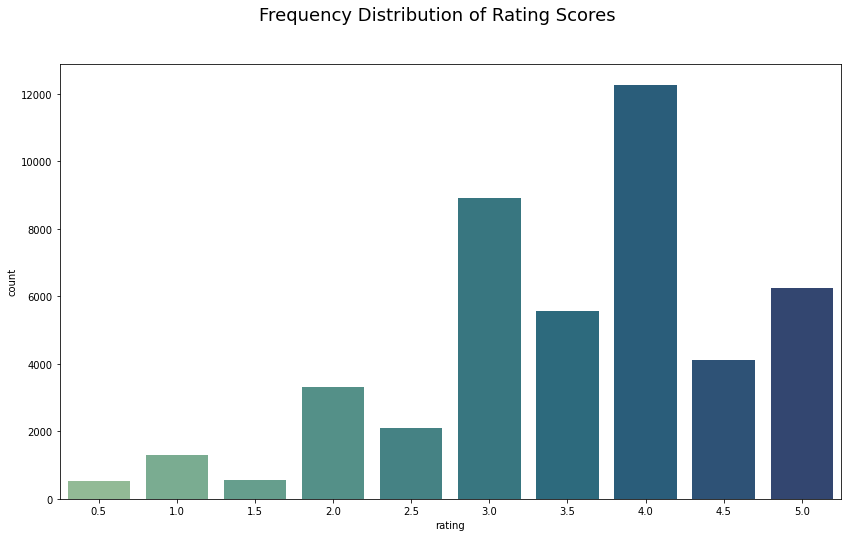

In [64]:
fig, ax = plt.subplots(figsize = (14,8))
sns.countplot(x = ratings.rating, palette="crest")
plt.suptitle('Frequency Distribution of Rating Scores', fontsize = 18)

Average Rating Genre

Text(0.5, 0.98, 'Average Rating per Genre')

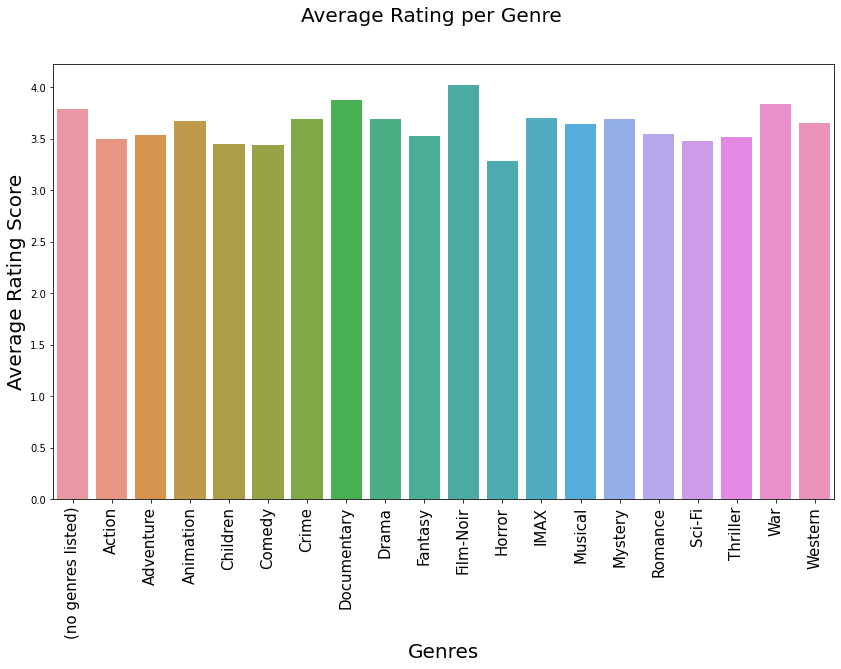

In [84]:
#subsetting the genres and rating columns from movie_ratings
genre_ratingdf = movie_ratings.loc[:,['genres', 'rating']]

# Unravel the genre columns
genre_ratingdf = genre_ratingdf.set_index(genre_ratingdf.columns.drop('genres',1).tolist()).genres.str.split('|', expand=True).stack().reset_index().rename(columns={0:'genres'}).loc[:, genre_ratingdf.columns]

# group by genres and their mean rating score and resetting the index
genre_mean_rating = pd.DataFrame(genre_ratingdf.groupby('genres')['rating'].mean()).reset_index()

# plotting the figure
fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x = 'genres', y = 'rating', data = genre_mean_rating)

ax.tick_params(axis='x', labelsize= 15, rotation=90)
ax.set_xlabel('Genres', fontsize= 20)
ax.set_ylabel('Average Rating Score',fontsize= 20)
plt.suptitle('Average Rating per Genre', fontsize= 20)

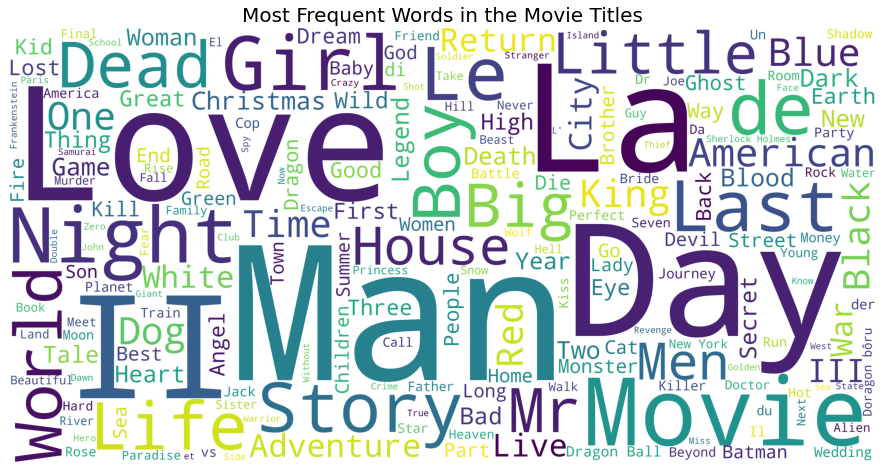

In [80]:
# Create a wordcloud of the movie titles
movies['title'] = movies['title'].fillna("").astype('str')
title_corpus = ' '.join(movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie Titles', fontsize = 20)
plt.show()

In [77]:
# getting the census of the genre keywords
genre_labels = set()
for genre in movies['genres'].str.split('|').values:
    genre_labels.update(genre)

# Function that gets the frequency distribution of the genre keywords
def keyword_count(dataset, column, keywords):
    keyword_dict = {key:0 for key in keywords}
    for genre in dataset[column].str.split('|'):                
        for key in [key for key in genre if key in keywords]: 
            if pd.notna(key): 
                keyword_dict[key] += 1
    
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_dict.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_dict

# Calling this function gives access to a list of genre keywords which are sorted by descending order of frequency
keyword_occurences, keyword_dict = keyword_count(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

**Wordcloud below shows the prevalence of genres in the dataset.**

Creating a bag of words for the genre keywords

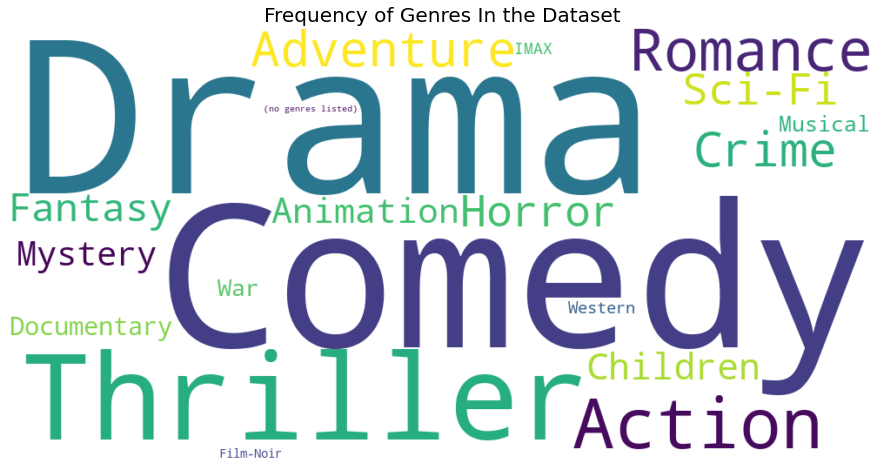

In [81]:
#Create the wordcloud of genres keywords
genre_wordcloud = WordCloud(width=1000,height=500, background_color='white')
genre_wordcloud.generate_from_frequencies(keyword_dict)

#Plot the wordcloud
fig, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Frequency of Genres In the Dataset', fontsize = 20)
plt.show()

**Content Based**

Merging the movie_ratings df with the tags df

This is because I want to use the genres as well as the tags for the recommendation system

In [23]:
mt_ratings = pd.merge(movie_ratings, tags).drop('timestamp', axis = 1)
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,magic board game
2,2,Jumanji (1995),Adventure|Children|Fantasy,62,4.0,Robin Williams
3,3,Grumpier Old Men (1995),Comedy|Romance,289,2.5,moldy
4,3,Grumpier Old Men (1995),Comedy|Romance,289,2.5,old


Splitting each genre variable, removing the '|' symbol and converting them to lowercase.

In [24]:
mt_ratings['genres'] = mt_ratings['genres'].apply(lambda x: ''.join(x.replace('|', ' ').lower()))
mt_ratings.head()

,movieId,title,genres,userId,rating,tag
0,2,Jumanji (1995),adventure children fantasy,62,4.0,fantasy
1,2,Jumanji (1995),adventure children fantasy,62,4.0,magic board game
2,2,Jumanji (1995),adventure children fantasy,62,4.0,Robin Williams
3,3,Grumpier Old Men (1995),comedy romance,289,2.5,moldy
4,3,Grumpier Old Men (1995),comedy romance,289,2.5,old



Creating a new column that takes in the features in genres and tag columns per row

In [25]:
def combined_features(row):
    return row['genres']+" "+row['tag']
mt_ratings["combined_features"] = mt_ratings.apply(combined_features, axis =1)
mt_ratings.sample(2)

,movieId,title,genres,userId,rating,tag,combined_features
424,115149,John Wick (2014),action thriller,62,5.0,stylish,action thriller stylish
393,107348,Anchorman 2: The Legend Continues (2013),comedy,62,4.0,Steve Carell,comedy Steve Carell


In [26]:
#resetting the index of the dataframe
mt_ratings.reset_index(inplace = True)

### **Making Recommendations based on the movie that a user likes**

Importing a class that I created which uses CountVectorizer from sklearn.feature_extraction.text to transform the combined_features column in mt_ratings into a matrix of token counts and cosine_similarity from sklearn.metrics.pairwise to calculate the cosine similarity on the vectorized column.

When the class is instantiated, it takes in the name of the movie and the mt_ratings dataframe.

It returns a list of top fifteen movies with the highest cosine similarity to a given movie title and these are recommended to the user.

In [29]:
from contentbasedrec import ContentBasedRec
%load_ext autoreload
%autoreload 2

In [30]:
# This randomly produces a movie title from our dataset to ensure that we get the right name and to make sure that we 
# choose a movie that is in the dataset. Using random_state to ensure reproducible results.
mt_ratings.sample(1, random_state = 42)['title']

158    Battle Royale (Batoru rowaiaru) (2000)
Name: title, dtype: object

In [31]:
movies_like_hulk  = ContentBasedRec('Hulk (2003)', mt_ratings)

In [32]:
movies_like_hulk.movie_list()

Here are a few recommendations for you


['Hulk (2003)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'X-Men (2000)',
 'Fantastic Four (2005)',
 'Fantastic Four: Rise of the Silver Surfer (2007)',
 'Green Lantern (2011)',
 'Avengers: Infinity War - Part I (2018)',
 'Batman v Superman: Dawn of Justice (2016)',
 'Postman, The (1997)',
 'Man of Steel (2013)',
 'Maze Runner, The (2014)',
 'Solo: A Star Wars Story (2018)',
 'Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku no Tobira) (2001)',
 'Animatrix, The (2003)',
 'The Hunger Games: Mockingjay - Part 2 (2015)']

**Collaborative Filtering**

In [33]:
# checking the unique number of user id and movie id in the ratings dataset
print(len(ratings['userId'].unique()), 'Number of user ids')
print(len(ratings['movieId'].unique()), 'Number of movie ids')

298 Number of user ids
6504 Number of movie ids


Reading the dataset into 'surprise'

In [34]:
#reading in the range of ratings score
reader = Reader(rating_scale = (1,5))
#loading the dataframe into surprise
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [35]:
dataset = data.build_full_trainset()

**Modeling**


The accuracy metric that I will focus on in this project is going to be the RMSE (root mean squared error). I will run a number of models and see which has the lowest rmse score. I will then use the best model moving forward.

**Cross validation with KNN Basic Model**

In [36]:
# using pearson correlation
knn_basic = KNNBasic(sim_options = {'name':'pearson', 'user_based':True})
cv_basic = cross_validate(knn_basic, data, n_jobs=-1)

for i in cv_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_basic['test_rmse']))

('test_rmse', array([1.00770228, 1.00972667, 0.99748941, 1.01456008, 1.01575022]))
('test_mae', array([0.78072474, 0.77951801, 0.7726752 , 0.78430776, 0.77947406]))
('fit_time', (0.15161490440368652, 0.153289794921875, 0.14926409721374512, 0.16154980659484863, 0.08246374130249023))
('test_time', (0.6531550884246826, 0.6753945350646973, 0.6712570190429688, 0.6396324634552002, 0.35557031631469727))
-----------------------
1.0090457325015758


In [37]:
#cross_validation with knnwithmeans
knn_means = KNNWithMeans(sim_options={'name':'pearson', 'user_based':True})
cv_means = cross_validate(knn_means, data, n_jobs=-1)

for i in cv_means.items():
    print(i)
print('-----------------------')
print(np.mean(cv_means['test_rmse']))

('test_rmse', array([0.93291256, 0.94607067, 0.92873254, 0.91685425, 0.93241749]))
('test_mae', array([0.70979662, 0.72376583, 0.71178048, 0.70124065, 0.71206126]))
('fit_time', (0.17467904090881348, 0.159149169921875, 0.15787482261657715, 0.15962457656860352, 0.09232187271118164))
('test_time', (0.7313079833984375, 0.7468554973602295, 0.7381460666656494, 0.7339975833892822, 0.4069046974182129))
-----------------------
0.9313975028592839


**Cross validation with KNNBaseline**

In [38]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_baseline = cross_validate(knn_baseline, data)

for i in cv_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_baseline['test_rmse']))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
('test_rmse', array([0.90700347, 0.9359873 , 0.90374285, 0.92311205, 0.91757526]))
('test_mae', array([0.69245721, 0.71573427, 0.69229144, 0.70597018, 0.70320751]))
('fit_time', (0.22643351554870605, 0.24637889862060547, 0.23629474639892578, 0.22440314292907715, 0.23032903671264648))
('test_time', (0.5746443271636963, 0.5676670074462891, 0.5673868656158447, 0.57570481300354, 0.5698869228363037))
-----------------------
0.917484185913095


**GridSearch with SVD using different parameters**

In [40]:
grid = {'n_factors' : [20,100],'n_epochs' : [5,10], 'reg_all' : [0.4, 0.6], 
               'lr_all' : [0.002, 0.005], }
gs_model = GridSearchCV(SVD, param_grid = grid, n_jobs = -1)
gs_model.fit(data)
print('gs_model best parameters:','\n', gs_model.best_params)
print('\n')
print('gs_model best score:', gs_model.best_score)

gs_model best parameters: 
 {'rmse': {'n_factors': 20, 'n_epochs': 10, 'reg_all': 0.4, 'lr_all': 0.005}, 'mae': {'n_factors': 20, 'n_epochs': 10, 'reg_all': 0.4, 'lr_all': 0.005}}


gs_model best score: {'rmse': 0.9016254079143542, 'mae': 0.6972895105152972}


In [41]:
grid2 = {'n_factors' : [10,90],'n_epochs' : [10,20], 'reg_all' : [0.1, 0.4], 
              'lr_all' : [0.005, 0.009], }
gs_model2 = GridSearchCV(SVD, param_grid = grid2, n_jobs = -1)
gs_model2.fit(data)

print('gs_model2 best parameters:','\n',gs_model2.best_params)
print('\n')
print('gs_model2 best score:', gs_model2.best_score)

gs_model2 best parameters: 
 {'rmse': {'n_factors': 90, 'n_epochs': 20, 'reg_all': 0.1, 'lr_all': 0.009}, 'mae': {'n_factors': 90, 'n_epochs': 20, 'reg_all': 0.1, 'lr_all': 0.009}}


gs_model2 best score: {'rmse': 0.8833797715357494, 'mae': 0.6786475211971476}


In [42]:
grid3 = {'n_factors' : [20,100],'n_epochs' : [20,30], 'reg_all' : [0.05, 0.1], 
              'lr_all' : [0.009, 0.01], }
gs_model3 = GridSearchCV(SVD, param_grid = grid3, n_jobs = -1)
gs_model3.fit(data)

print('gs_model3 best parameters:','\n',gs_model3.best_params)
print('\n')
print('gs_model3 best score:', gs_model3.best_score)

gs_model3 best parameters: 
 {'rmse': {'n_factors': 100, 'n_epochs': 30, 'reg_all': 0.1, 'lr_all': 0.009}, 'mae': {'n_factors': 100, 'n_epochs': 30, 'reg_all': 0.1, 'lr_all': 0.009}}


gs_model3 best score: {'rmse': 0.879521679883136, 'mae': 0.6760396802699559}


In [43]:
grid4 = {'n_factors' : [20,100],'n_epochs' : [30,40], 'reg_all' : [0.1, 0.2], 
              'lr_all' : [0.01, 0.05], }
gs_model4 = GridSearchCV(SVD, param_grid = grid4, n_jobs = -1)
gs_model4.fit(data)

print('gs_model4 best parameters:','\n',gs_model4.best_params)
print('\n')
print('gs_model4 best score:', gs_model4.best_score)

gs_model4 best parameters: 
 {'rmse': {'n_factors': 100, 'n_epochs': 40, 'reg_all': 0.1, 'lr_all': 0.01}, 'mae': {'n_factors': 100, 'n_epochs': 40, 'reg_all': 0.1, 'lr_all': 0.01}}


gs_model4 best score: {'rmse': 0.8779189273601491, 'mae': 0.6737117624465927}


In [44]:
grid5 = {'n_factors' : [20,100],'n_epochs' : [40,60], 'reg_all' : [0.1, 0.2], 
              'lr_all' : [0.01, 0.05], }
gs_model5 = GridSearchCV(SVD, param_grid = grid5, n_jobs = -1)
gs_model5.fit(data)

print('gs_model5 best parameters:','\n', gs_model5.best_params)
print('\n')
print('gs_model5 best score:', gs_model5.best_score)

gs_model5 best parameters: 
 {'rmse': {'n_factors': 100, 'n_epochs': 60, 'reg_all': 0.1, 'lr_all': 0.01}, 'mae': {'n_factors': 100, 'n_epochs': 60, 'reg_all': 0.1, 'lr_all': 0.01}}


gs_model5 best score: {'rmse': 0.8768221710586804, 'mae': 0.6735958470235353}


**Line plot visualizing the rmse vs model**

Text(0, 0.5, 'RMSE Score')

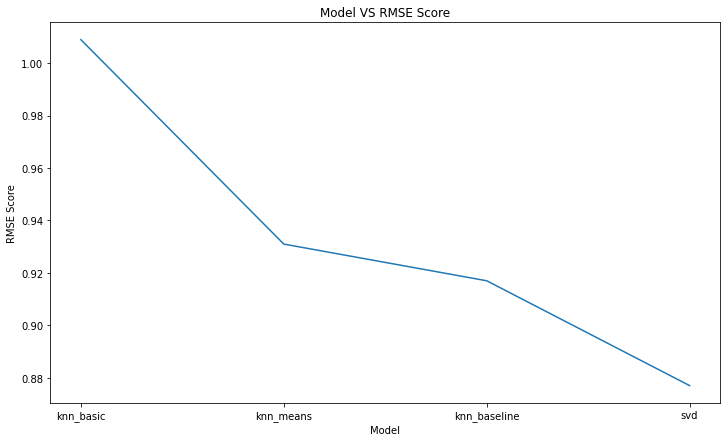

In [45]:
# making a dataframe with all the models and their rmse
model_list = [['knn_basic',round(np.mean(cv_basic['test_rmse']),3)], ['knn_means',round(np.mean(cv_means['test_rmse']),3)], 
              ['knn_baseline', round(np.mean(cv_baseline['test_rmse']),3)], ['svd',round(gs_model5.best_score['rmse'],3)]]
model_scores = pd.DataFrame(model_list, columns = ['model_name', 'model_rmse'])

# Line plot visualizing the rmse vs model
fig, ax = plt.subplots(figsize = (12,7))

x = model_scores['model_name']
y = model_scores['model_rmse']
plt.plot(x, y)
plt.title('Model VS RMSE Score')
plt.xlabel('Model')
plt.ylabel('RMSE Score')

**Example prediction of ratings**

In [46]:
svd = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)
svd.fit(dataset)

In [47]:
svd.predict(2, 35)

Prediction(uid=2, iid=35, r_ui=None, est=3.6271425942533315, details={'was_impossible': False})

**Making some recommendations using SVD**

In [48]:
# movie_df is the df that contains the movie title, id and genres, num refer to the number of movie ratings required to 
# be given by the user
def movie_rater(movie_df,num, genre=None):
#     choosing 1000 to ensure we do not overwrite an already existing userid
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [54]:
# gets user ratings for movies the user has watched
user_rating = movie_rater(movies, 2, 'Thriller')

      movieId                title                         genres
3421     4658  Santa Sangre (1989)  Drama|Horror|Mystery|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                   title                              genres
5570    26764  Captain America (1990)  Action|Fantasy|Sci-Fi|Thriller|War
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
      movieId  ...           genres
2096     2790  ...  Horror|Thriller

[1 rows x 3 columns]
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId                 title                       genres
8793   129937  Run All Night (2015)  Action|Crime|Drama|Thriller
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
      movieId               title                                  genres
2354     3113  End of Days (1999)  Action|Fantasy|Horror|Mystery|Thriller
How do you rate this movie on a 

In [55]:
# append the user_rating result to the end of the ratings df which has the userid, movieid, and ratings
new_ratings_df = ratings.append(user_rating,ignore_index=True)
# load into surprise
new_data = Dataset.load_from_df(new_ratings_df,reader)
# build the train data set
new_dataset = new_data.build_full_trainset()

In [56]:
# fit the svd model tot he new dataset
svd_ = SVD(n_factors= 100, n_epochs = 60, reg_all=0.1, lr_all=0.01)
svd_.fit(new_dataset)

In [57]:
# this creates a list of tuples (movie_id, predicted_rating) in descending order of rating score
list_of_movies = []
for movie_id in ratings['movieId'].unique():
    list_of_movies.append( (movie_id,svd_.predict(1000,movie_id)[3]))
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)


The function below takes in the ranked_movies from the result above, the movies dataframe and the number of movie recommendations desired by the user and returns the top five highly rated movie based on what out model predicted for the user

In [58]:
def recommended_movies(predicted_ratings,movie_title_df,n):
        for idx, rec in enumerate(predicted_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Here are 5 movies we recommend for you to watch:','\n')
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Here are 5 movies we recommend for you to watch: 

Recommendation #  1 :  983    Big Sleep, The (1946)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  2 :  7704    The Artist (2011)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  3 :  9618    Three Billboards Outside Ebbing, Missouri (2017)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  4 :  8290    Dallas Buyers Club (2013)
Name: title, dtype: object 

Here are 5 movies we recommend for you to watch: 

Recommendation #  5 :  5037    Dune (2000)
Name: title, dtype: object 

